<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  1000 non-null   object
 1   user_id    1000 non-null   int64 
 2   action     1000 non-null   object
 3   resource   1000 non-null   object
 4   label      1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    1000 non-null   object
 1   user_id      1000 non-null   int64 
 2   auth_method  1000 non-null   object
 3   status       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  -----

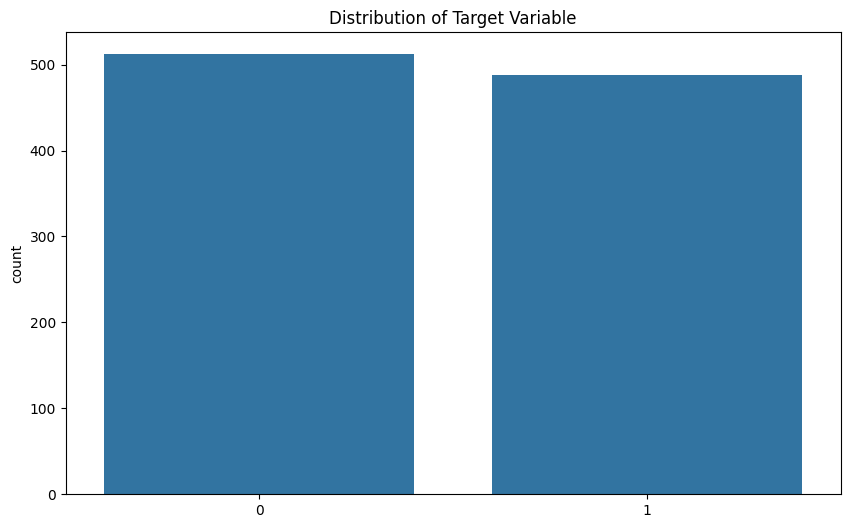

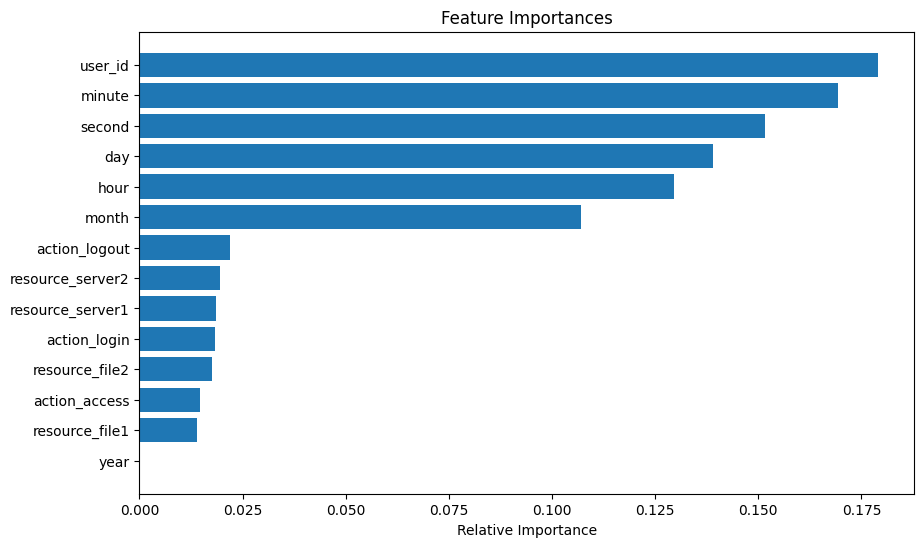

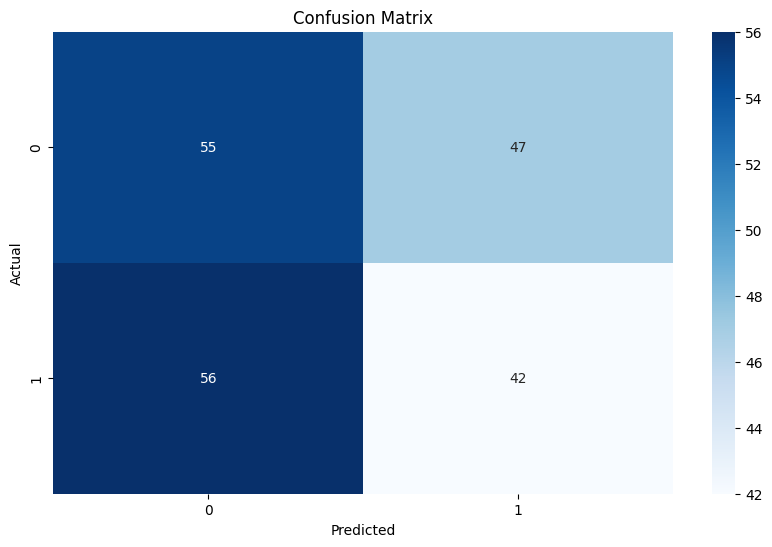

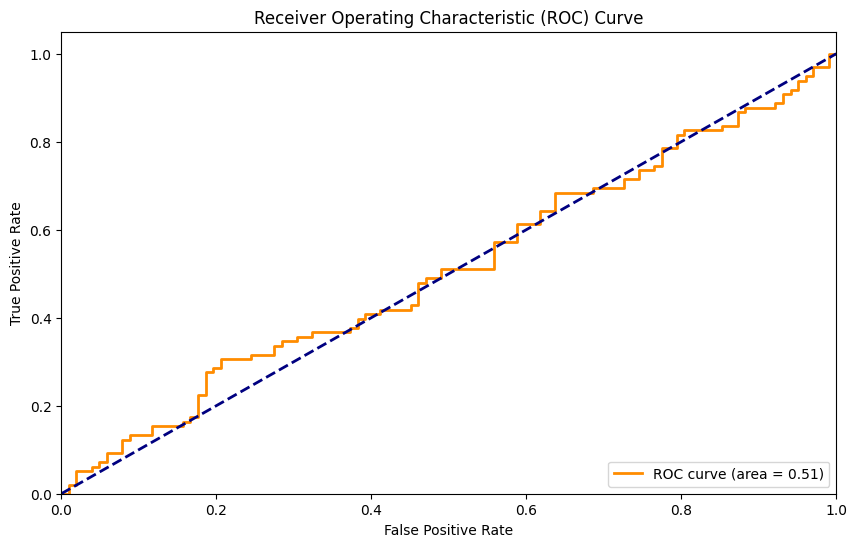

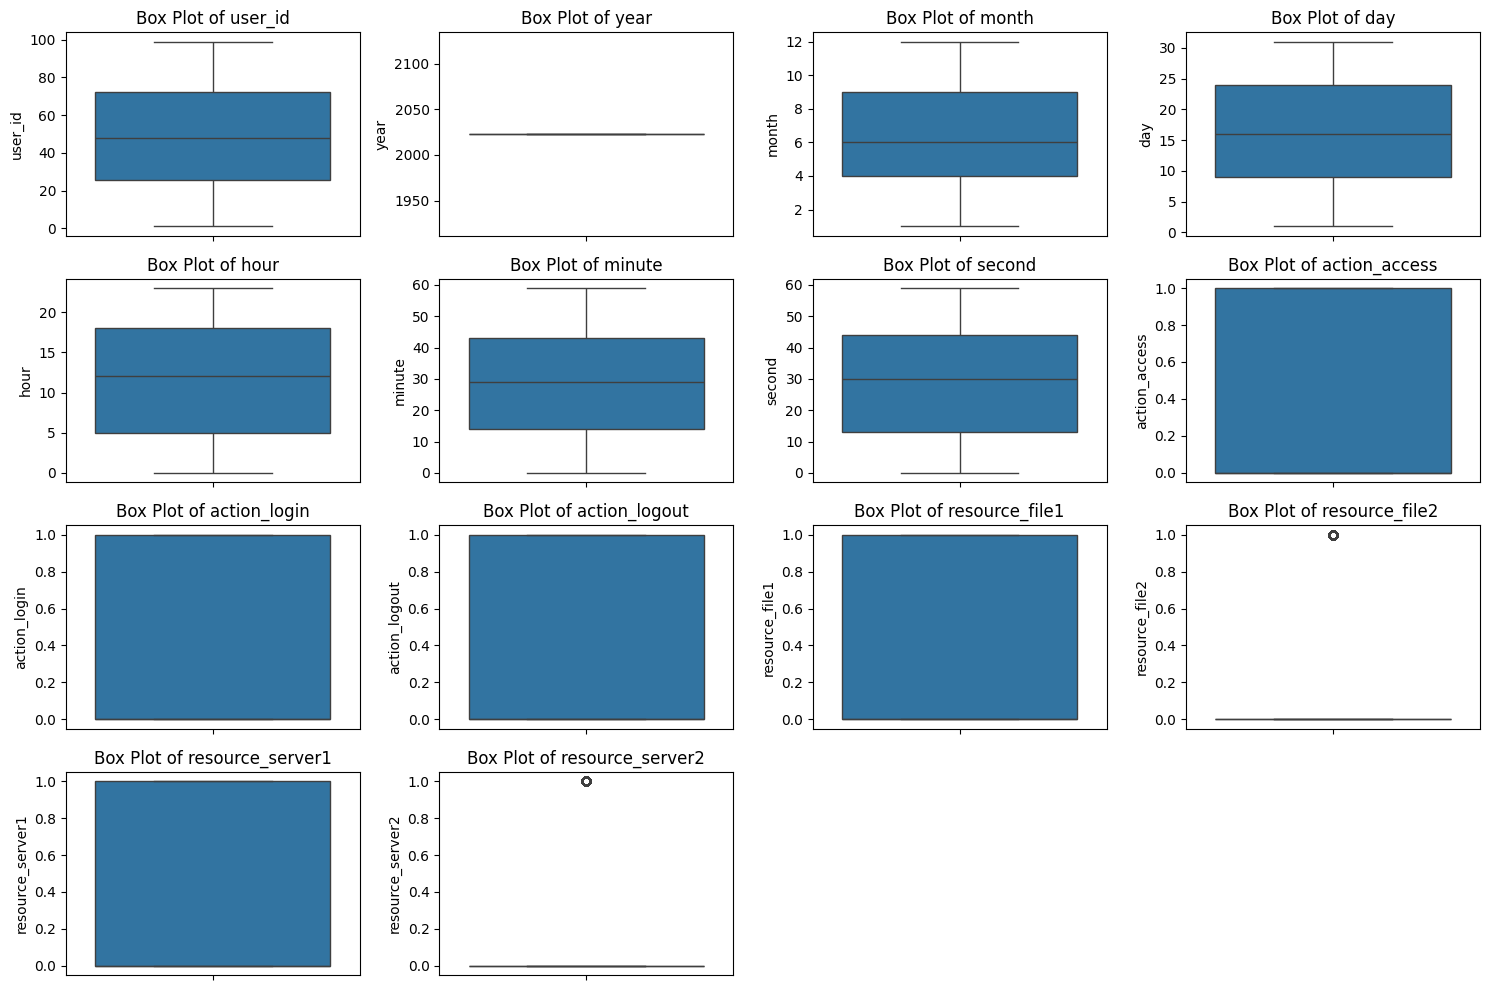

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define the path to the training data
train_data = 'extraction/train_data'

# Load each CSV file into separate dataframes
access_logs_df = pd.read_csv(os.path.join(train_data, 'access_logs.csv'))
auth_logs_df = pd.read_csv(os.path.join(train_data, 'auth_logs.csv'))
network_logs_df = pd.read_csv(os.path.join(train_data, 'network_logs.csv'))

# Display basic info of each dataframe to understand structure and available features
print(access_logs_df.info())
print(auth_logs_df.info())
print(network_logs_df.info())

# Display first few rows of each dataframe for further exploration
print(access_logs_df.head())
print(auth_logs_df.head())
print(network_logs_df.head())

# Preprocess the data
# Convert timestamp to datetime
access_logs_df['timestamp'] = pd.to_datetime(access_logs_df['timestamp'])

# Extract features from timestamp
access_logs_df['year'] = access_logs_df['timestamp'].dt.year
access_logs_df['month'] = access_logs_df['timestamp'].dt.month
access_logs_df['day'] = access_logs_df['timestamp'].dt.day
access_logs_df['hour'] = access_logs_df['timestamp'].dt.hour
access_logs_df['minute'] = access_logs_df['timestamp'].dt.minute
access_logs_df['second'] = access_logs_df['timestamp'].dt.second

# Drop the original timestamp column
access_logs_df = access_logs_df.drop('timestamp', axis=1)

# One-hot encode categorical features
access_logs_df = pd.get_dummies(access_logs_df, columns=['action', 'resource'])

# Assuming 'label' is the target column and the rest are features
X = access_logs_df.drop('label', axis=1)
y = access_logs_df['label']

# Encode labels if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.show()

# Plot feature importance
feature_importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot outliers using box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=X[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Load images from the directory
def load_images_from_directory(directory):
    image_files = [f for f in os.listdir(directory) if f.endswith(('.bmp', '.png', '.jpg', '.jpeg'))]
    images = []
    labels = []
    for file in image_files:
        image_path = os.path.join(directory, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        image = cv2.resize(image, (128, 128))
        image = image / 255.0  # Normalize pixel values to [0, 1]
        images.append(image.flatten())  # Flatten the image to create a feature vector
        label = 1 if 'genuine' in file else 0  # Example label extraction logic
        labels.append(label)
    return np.array(images), np.array(labels)

# Train the logistic regression model and plot training/validation curves
def train_and_plot_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression(max_iter=1000)
    train_accuracies = []
    val_accuracies = []

    for i in range(1, 101):
        model.max_iter = i
        model.fit(X_train, y_train)
        train_accuracy = model.score(X_train, y_train)
        val_accuracy = model.score(X_val, y_val)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    plt.plot(range(1, 101), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, 101), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    return model

# Example usage
if __name__ == '__main__':
    # Directory containing the images
    image_dir = 'extraction/train_data'

    # Load images and labels from the directory
    X, y = load_images_from_directory(image_dir)

    # Split the data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Train the logistic regression model and plot training/validation curves
    model = train_and_plot_model(X_train, y_train, X_val, y_val)

    # Save the trained model
    joblib.dump(model, 'logistic_regression_model.pkl')

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test AUC: {auc}")

    # Optional: Load and use the model
    # loaded_model = joblib.load('logistic_regression_model.pkl')
    # predictions = loaded_model.predict(X_test)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

Total number of images in the dataset: 800
Displaying sample image: extraction/train_data/00009_62.bmp


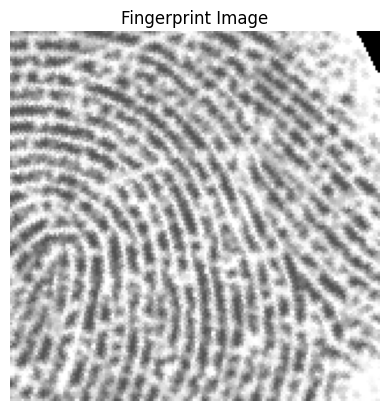

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Path to the dataset directory
dataset_dir = 'extraction/train_data'

# Function to count the total number of images in the dataset
def count_images(dataset_dir):
    total_images = 0
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                total_images += 1
    return total_images

# Function to get a random sample image path from the dataset
def get_sample_image_path(dataset_dir):
    image_paths = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(root, file))
    return random.choice(image_paths) if image_paths else None

# Function to display a fingerprint image
def display_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    plt.title('Fingerprint Image')
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == '__main__':
    # Count the total number of images in the dataset
    total_images = count_images(dataset_dir)
    print(f'Total number of images in the dataset: {total_images}')

    # Get a sample fingerprint image path
    sample_image_path = get_sample_image_path(dataset_dir)
    if sample_image_path:
        print(f'Displaying sample image: {sample_image_path}')
        display_image(sample_image_path)
    else:
        print('No images found in the dataset.')

Image Dimensions: (160, 160)
Image Data Type: uint8
Image Min Pixel Value: 22
Image Max Pixel Value: 255


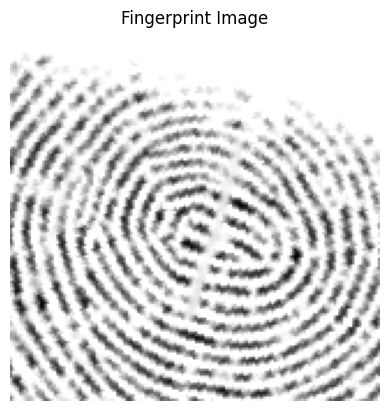

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample fingerprint image
def load_sample_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    return image

# Display basic information about the image
def display_image_info(image):
    print(f"Image Dimensions: {image.shape}")
    print(f"Image Data Type: {image.dtype}")
    print(f"Image Min Pixel Value: {np.min(image)}")
    print(f"Image Max Pixel Value: {np.max(image)}")

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.title('Fingerprint Image')
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == '__main__':
    # Load a sample fingerprint image
    sample_image_path = 'extraction/train_data/sample_image.png'  # Ensure this path points to a valid image file
    sample_image = load_sample_image(sample_image_path)

    # Display basic information about the image
    display_image_info(sample_image)

Missing Values in Each Column:
timestamp    0
user_id      0
action       0
resource     0
label        0
dtype: int64


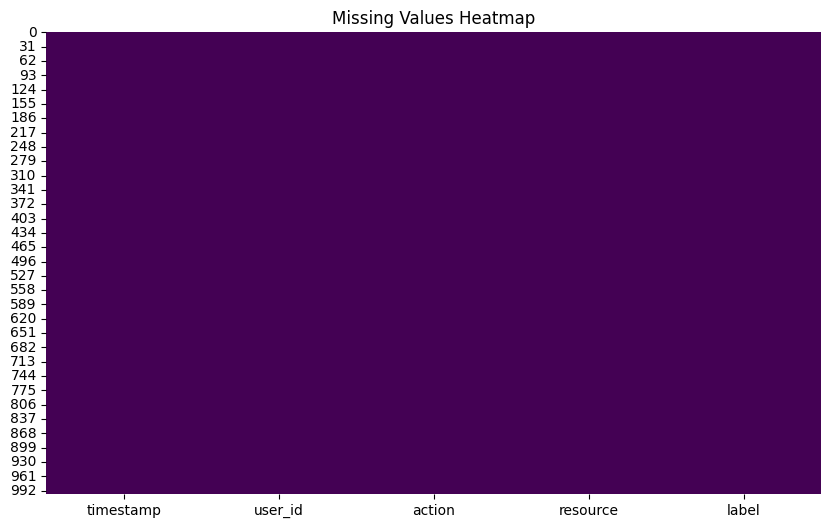

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
def load_dataset(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found at path: {file_path}")

# Check for missing values
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing Values in Each Column:")
    print(missing_values)

    # Visualize missing values
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

# Example usage
if __name__ == '__main__':
    # Path to the dataset file
    dataset_file_path = 'extraction/train_data/access_logs.csv'  # Ensure this path points to a valid CSV file

    # Load the dataset
    df = load_dataset(dataset_file_path)

    # Check for missing values
    check_missing_values(df)

/home/adam/Downloads/SIM_Alert/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/adam/Downloads/SIM_Alert/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

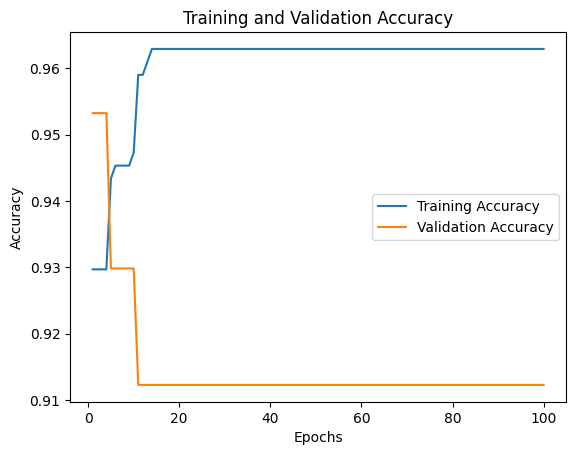

Test Accuracy: 0.8830409356725146
Test Precision: 0.0
Test Recall: 0.0
Test AUC: 0.468944099378882


In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib

# Load images from the directory
def load_images_from_directory(directory, label):
    image_files = [f for f in os.listdir(directory) if f.endswith(('.bmp', '.png', '.jpg', '.jpeg'))]
    images = []
    labels = []
    for file in image_files:
        image_path = os.path.join(directory, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        image = cv2.resize(image, (128, 128))
        image = image / 255.0  # Normalize pixel values to [0, 1]
        images.append(image.flatten())  # Flatten the image to create a feature vector
        labels.append(label)
    return np.array(images), np.array(labels)

# Generate synthetic data using data augmentation
def generate_synthetic_data(images, labels, num_samples):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    synthetic_images = []
    synthetic_labels = []
    for i in range(num_samples):
        for x, y in datagen.flow(images.reshape(-1, 128, 128, 1), labels, batch_size=1):
            synthetic_images.append(x.flatten())
            synthetic_labels.append(y[0])
            if len(synthetic_images) >= num_samples:
                break
        if len(synthetic_images) >= num_samples:
            break
    return np.array(synthetic_images), np.array(synthetic_labels)

# Train the logistic regression model and plot training/validation curves
def train_and_plot_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression(max_iter=1000)
    train_accuracies = []
    val_accuracies = []

    for i in range(1, 101):
        model.max_iter = i
        model.fit(X_train, y_train)
        train_accuracy = model.score(X_train, y_train)
        val_accuracy = model.score(X_val, y_val)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    plt.plot(range(1, 101), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, 101), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    return model

# Example usage
if __name__ == '__main__':
    # Directories containing the genuine and forged images
    genuine_image_dir = 'extraction/train_data/genuine'
    forged_image_dir = 'extraction/train_data'

    # Load genuine images and labels
    genuine_images, genuine_labels = load_images_from_directory(genuine_image_dir, label=1)

    # Load forged images and labels
    forged_images, forged_labels = load_images_from_directory(forged_image_dir, label=0)

    # Check if any images were loaded
    if len(genuine_images) == 0 or len(forged_images) == 0:
        raise ValueError("No images were loaded. Please check the directories and ensure they contain image files.")

    # Combine genuine and forged data
    X = np.concatenate((genuine_images, forged_images), axis=0)
    y = np.concatenate((genuine_labels, forged_labels), axis=0)

    # Check if the dataset contains at least two classes
    if len(np.unique(y)) < 2:
        raise ValueError("The dataset must contain at least two classes.")

    # Split the data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Train the logistic regression model and plot training/validation curves
    model = train_and_plot_model(X_train, y_train, X_val, y_val)

    # Save the trained model
    joblib.dump(model, 'logistic_regression_model.pkl')

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test AUC: {auc}")

    # Optional: Load and use the model
    # loaded_model = joblib.load('logistic_regression_model.pkl')
    # predictions = loaded_model.predict(X_test)